In [1]:
from concurrent import futures
import logging
import math
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

import grpc
import RemoteCam_pb2
import RemoteCam_pb2_grpc

PORT_CAM = 10509
HOST_IP = "localhost"

### Put correct host address and test

request 0 -> response 0


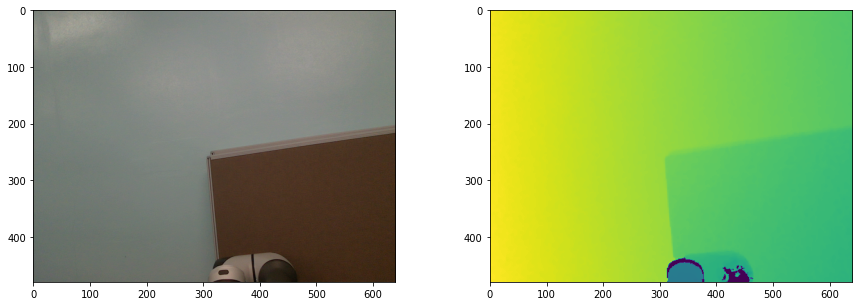

In [2]:
host = "localhost"
with grpc.insecure_channel('{}:{}'.format(host, PORT_CAM)) as channel:
    stub = RemoteCam_pb2_grpc.RemoteCamProtoStub(channel) 
    request_id = 0
    resp = stub.GetImage(RemoteCam_pb2.GetImageRequest(request_id=request_id))
    print("request {} -> response {}".format(request_id, resp.response_id))
    color = np.array(resp.color).reshape((resp.height, resp.width, 3))
    depth = np.array(resp.depth).reshape((resp.height, resp.width))
    width = resp.width
    height= resp.height
    
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(color)
plt.subplot(1,2,2)
plt.imshow(depth)

In [3]:
host = "localhost"
with grpc.insecure_channel('{}:{}'.format(host, PORT_CAM)) as channel:
    stub = RemoteCam_pb2_grpc.RemoteCamProtoStub(channel) 
    request_id = 0
    resp = stub.GetConfig(RemoteCam_pb2.GetConfigRequest(request_id=request_id))
    print("request {} -> response {}".format(request_id, resp.response_id))
    cam_mtx = np.array(resp.camera_matrix).reshape((3, 3))
    dist_coeffs = np.array(resp.dist_coeffs).reshape((5,))
    depth_scale = resp.depth_scale
    print("Camera Marix: \n{}".format(cam_mtx))
    print("Distortion Coeffs: \n{}".format(dist_coeffs))
    print("Depth Scale: \n{}".format(depth_scale))

request 0 -> response 0
Camera Marix: 
[[599.36883545   0.         329.92245483]
 [  0.         599.47363281 235.28637695]
 [  0.           0.           1.        ]]
Distortion Coeffs: 
[ 0.15870179 -0.46903715 -0.0014261   0.00066797  0.41631824]
Depth Scale: 
0.0002500000118743628


In [5]:
import SharedArray as sa

In [6]:
IMG_URI = "shm://return_img"
REQ_URI = "shm://request"
RESP_URI = "shm://response"

return_img_p = None
request_p = None
resp_p = None

In [7]:
class SharedDetector:
    def __init__(self):
        print("=============================================")


    def save_img(self, img_name):
        with grpc.insecure_channel('{}:{}'.format(host, PORT_CAM)) as channel:
            stub = RemoteCam_pb2_grpc.RemoteCamProtoStub(channel) 
            request_id = 0
            resp = stub.GetImage(RemoteCam_pb2.GetImageRequest(request_id=request_id))
            print("request {} -> response {}".format(request_id, resp.response_id))
            color = np.array(resp.color).reshape((resp.height, resp.width, 3))
            depth = np.array(resp.depth).reshape((resp.height, resp.width))
            width = resp.width
            height= resp.height
            cv2.imwrite("{}.jpg".format(img_name), color)
            cv2.imwrite("{}.jpg".format(img_name), depth)
    
    def save_config(self):
        
    def serve_forever(self):
        self.request[:] = 0
        self.resp[:] = 0
        print("===== Ready Image Sending Server =====")
        print("=============================================")
        while True:
            while not self.request[:]:
                time.sleep(0.01)
            self.request[:] = 0
            self.resp[:] = 0
            
            self.return_img[:,:,:3] = color_img
            self.return_img[:,:,3] = depth_img
            
            print("====== Success to Send Image ======")
            print("=============================================")
            self.resp[:] = 1

            
    def __enter__(self):
        try:
#            sa.delete(COLOR_URI)
            sa.delete(IMG_URI)
            sa.delete(REQ_URI)
            sa.delete(RESP_URI)
        except Exception as e:
            pass
        
#        self.color_img = sa.create(COLOR_URI, (height, width, 3), dtype=np.uint16)
 #       self.depth_img = sa.create(DEPTH_URI, (height, width), dtype=np.uint16)
        self.return_img = sa.create(IMG_URI, (height,width,4), dtype=np.uint16)
        self.request = sa.create(REQ_URI, (1,), dtype=np.uint8)
        self.resp = sa.create(RESP_URI, (1,), dtype=np.uint8)
        self.request[:] = 0
        self.resp[:] = 0

    def __exit__(self, type, value, traceback):
        sa.delete(IMG_URI)
        sa.delete(REQ_URI)
        sa.delete(RESP_URI)

In [8]:
if __name__ == "__main__":
    sdet = SharedDetector()
    with sdet:
        sdet.serve_forever()

===== Ready Image Sending Server =====


KeyboardInterrupt: 